In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install datasets
!pip install -U ultralytics
!pip install -U albumentations
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 19.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.7/680.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 11.4 MB/s eta 0:00:00


### Important Imports

In [3]:
from datasets import load_dataset
# Import the necessary function
from datasets import load_from_disk

### Downloading Dataset

In [4]:
# Load Human Parsing Dataset
dataset = load_dataset("mattmdjaga/human_parsing_dataset")


# Save dataset to disk
dataset.save_to_disk("./human_parsing_dataset")

README.md:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

(…)-00000-of-00002-f3a663f7140ee7fd.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

(…)-00001-of-00002-74610e243c32d5d6.parquet:   0%|          | 0.00/403M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17706 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/17706 [00:00<?, ? examples/s]

In [7]:


dataset = load_from_disk("/kaggle/working/human_parsing_dataset")

## Data Preparation

In [10]:
import os
import numpy as np
from PIL import Image
import cv2
from pathlib import Path
from tqdm.auto import tqdm
import shutil
from sklearn.model_selection import train_test_split

class YOLODataPreparer:
    def __init__(self, dataset, output_dir, val_split=0.2, min_points=3):
        """
        Initialize the data preparer for YOLO segmentation
        
        Args:
            dataset: HuggingFace dataset with 'image' and 'mask' features
            output_dir: Directory where the YOLO format dataset will be saved
            val_split: Validation split ratio (default: 0.2)
            min_points: Minimum points for polygon (default: 3)
        """
        self.dataset = dataset
        self.output_dir = Path(output_dir)
        self.val_split = val_split
        self.min_points = min_points
        
        # Create directory structure
        self.image_train_dir = self.output_dir / 'images' / 'train'
        self.image_val_dir = self.output_dir / 'images' / 'val'
        self.label_train_dir = self.output_dir / 'labels' / 'train'
        self.label_val_dir = self.output_dir / 'labels' / 'val'
        
        self._create_directories()
        
    def _create_directories(self):
        """Create the necessary directory structure"""
        for dir_path in [self.image_train_dir, self.image_val_dir, 
                        self.label_train_dir, self.label_val_dir]:
            dir_path.mkdir(parents=True, exist_ok=True)
            
    def extract_polygons(self, mask, class_idx):
        """
        Extract polygon coordinates for a specific class from the mask
        
        Args:
            mask: numpy array of the mask
            class_idx: class index to extract
            
        Returns:
            list of normalized polygon coordinates
        """
        # Create binary mask for this class
        binary_mask = (mask == class_idx).astype(np.uint8)
        
        # Find contours
        contours, _ = cv2.findContours(binary_mask, 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        
        height, width = mask.shape
        polygons = []
        
        for contour in contours:
            # Skip if contour is too small
            if len(contour) < self.min_points:
                continue
                
            # Simplify contour to reduce points while maintaining shape
            epsilon = 0.005 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Ensure minimum points requirement
            if len(approx) < self.min_points:
                continue
                
            # Normalize coordinates
            polygon = approx.reshape(-1, 2).astype(float)
            polygon[:, 0] /= width  # normalize x
            polygon[:, 1] /= height  # normalize y
            
            polygons.append(polygon)
            
        return polygons
    
    def process_single_sample(self, image, mask, output_image_path, output_label_path):
        """
        Process a single sample and save image and label files
        
        Args:
            image: PIL Image
            mask: PIL Image in L mode
            output_image_path: path to save the image
            output_label_path: path to save the label file
        """
        # Save image
        image.save(output_image_path)
        
        # Convert mask to numpy array
        mask_array = np.array(mask)
        
        # Process each class
        label_lines = []
        for class_idx in range(18):  # 18 classes as per your data
            polygons = self.extract_polygons(mask_array, class_idx)
            
            for polygon in polygons:
                # Format coordinates for YOLO
                coords = polygon.flatten().tolist()
                if len(coords) >= self.min_points * 2:  # Ensure minimum points
                    line = f"{class_idx} " + " ".join(map(str, coords))
                    label_lines.append(line)
        
        # Save label file if we found any valid polygons
        if label_lines:
            with open(output_label_path, 'w') as f:
                f.write('\n'.join(label_lines))
                
    def prepare_data(self):
        """
        Process the entire dataset and prepare it in YOLO format
        """
        # Create train/val splits
        indices = list(range(len(self.dataset['train'])))
        train_indices, val_indices = train_test_split(
            indices, test_size=self.val_split, random_state=42
        )
        
        # Process training set
        for idx in tqdm(train_indices, desc="Processing training set"):
            sample = self.dataset['train'][idx]
            image_path = self.image_train_dir / f"{idx:06d}.jpg"
            label_path = self.label_train_dir / f"{idx:06d}.txt"
            self.process_single_sample(sample['image'], sample['mask'], 
                                    image_path, label_path)
            
        # Process validation set
        for idx in tqdm(val_indices, desc="Processing validation set"):
            sample = self.dataset['train'][idx]
            image_path = self.image_val_dir / f"{idx:06d}.jpg"
            label_path = self.label_val_dir / f"{idx:06d}.txt"
            self.process_single_sample(sample['image'], sample['mask'], 
                                    image_path, label_path)
            
        # Create YAML configuration
        self.create_yaml_config()
    
    def create_yaml_config(self):
        """Create the YAML configuration file for YOLO"""
        yaml_content = {
            'path': str(self.output_dir.absolute()),
            'train': 'images/train',
            'val': 'images/val',
            'names': {
                0: 'background',
                1: 'hat',
                2: 'hair',
                3: 'glove',
                4: 'sunglasses',
                5: 'upper_clothes',
                6: 'dress',
                7: 'coat',
                8: 'socks',
                9: 'pants',
                10: 'jumpsuits',
                11: 'scarf',
                12: 'skirt',
                13: 'face',
                14: 'left_arm',
                15: 'right_arm',
                16: 'left_leg',
                17: 'right_leg'
            }
        }
        
        import yaml
        with open(self.output_dir / 'data.yaml', 'w') as f:
            yaml.dump(yaml_content, f, sort_keys=False)

In [11]:
# Initialize the data preparer
preparer = YOLODataPreparer(
    dataset=dataset,
    output_dir="./YOLO_Dataset",
    val_split=0.2,  # 80% train, 20% validation
    min_points=3    # minimum points for polygons
)

# Prepare the data
preparer.prepare_data()

Processing training set:   0%|          | 0/14164 [00:00<?, ?it/s]

Processing validation set:   0%|          | 0/3542 [00:00<?, ?it/s]

In [6]:
import yaml

# Define the dataset information
data = {
    'path': '/kaggle/working/YOLO_Dataset',
    'train': '/kaggle/working/YOLO_Dataset/images/train',
    'val': '/kaggle/working/YOLO_Dataset/images/val',
    'names': {
        0: 'background',
        1: 'hat',
        2: 'hair',
        3: 'glove',
        4: 'sunglasses',
        5: 'upper_clothes',
        6: 'dress',
        7: 'coat',
        8: 'socks',
        9: 'pants',
        10: 'jumpsuits',
        11: 'scarf',
        12: 'skirt',
        13: 'face',
        14: 'left_arm',
        15: 'right_arm',
        16: 'left_leg',
        17: 'right_leg'
    }
}

# Write to a YAML file
with open('/kaggle/working/YOLO_Dataset/data.yaml', 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

print("YAML file created successfully.")


YAML file created successfully.


## Model Training

In [ ]:
from dataclasses import dataclass, asdict
from ultralytics import YOLO  # Adding the import that was missing

@dataclass
class Config:
    data: str
    model_size: str
    model_name: str
    epochs: int
    batch_size: int
    img_size: int
    patience: int
    save: bool
    project: str
    exist_ok: bool
    val: bool
    plots: bool
    save_period: int

class Trainer:
    """
    Trainer class for YOLO model training.
    """

    def __init__(self, config: Config):
        """
        Initialize the Trainer class.

        Args:
            config (Config): Configuration instance.
        """
        self.config = config
        self.model = YOLO(f"yolo11n-seg.pt")

    def train(self):
        """
        Train the YOLO model using the configuration parameters.
        Converts the config dataclass to a dictionary of training arguments.
        """
        try:
            # Convert config to dictionary and remove model-specific attributes
            train_args = asdict(self.config)
            # Remove attributes that aren't training parameters
            train_args.pop('model_size')
            train_args.pop('model_name')

            # Train the model with unpacked arguments
            self.model.train(
                data=train_args['data'],
                epochs=train_args['epochs'],
                batch=train_args['batch_size'],
                imgsz=train_args['img_size'],
                patience=train_args['patience'],
                project=train_args['project'],
                exist_ok=train_args['exist_ok'],
                val=train_args['val'],
                plots=train_args['plots'],
                save_period=train_args['save_period'],
                save=train_args['save']
            )
            print("Model training completed successfully.")
        except Exception as e:
            print(f"Error during model training: {str(e)}")
            raise  # Re-raise the exception for proper error handling

def main():
    # Define model size
    model_size = "n"  # Options: "n", "s", "m", "l", "x"

    # Configuration instance
    config = Config(
        data="/kaggle/working/YOLO_Dataset/data.yaml",
        model_size=model_size,
        model_name=f"yolo11{model_size}-seg",
        epochs=100,
        batch_size=32,
        img_size=640,
        patience=50,
        save=True,
        project="Yolo11n_seg",
        exist_ok=True,
        val=True,
        plots=True,
        save_period=10,
    )

    trainer = Trainer(config)
    trainer.train()

if __name__ == "__main__":
    main()

Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/kaggle/working/YOLO_Dataset/data.yaml, epochs=100, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=Yolo11n_seg, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 19.8MB/s]
2024-11-03 17:49:36,798	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-03 17:49:37,217	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=18

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 92.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/YOLO_Dataset/labels/train.cache... 14164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14164/14164 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/YOLO_Dataset/labels/val.cache... 3542 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3542/3542 [00:00<?, ?it/s]


Plotting labels to Yolo11n_seg/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Yolo11n_seg/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.6G      1.165      2.263      2.818      1.206        540        640: 100%|██████████| 443/443 [12:29<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:41<00:00,  1.36it/s]


                   all       3542      59845      0.553      0.472      0.404      0.264      0.555      0.473      0.406      0.253

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       8.8G       1.02      1.859      1.334      1.124        737        640: 100%|██████████| 443/443 [12:18<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:41<00:00,  1.36it/s]


                   all       3542      59845      0.564      0.512      0.447      0.294      0.573      0.515      0.452      0.281

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.7G      1.035      1.859      1.263      1.129        605        640: 100%|██████████| 443/443 [12:21<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:42<00:00,  1.32it/s]


                   all       3542      59845      0.489      0.502      0.427       0.27      0.496      0.505       0.43      0.258

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.74G      1.043      1.869      1.237      1.134        638        640: 100%|██████████| 443/443 [12:19<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:42<00:00,  1.32it/s]


                   all       3542      59845       0.51       0.52      0.444      0.286       0.52       0.52      0.449      0.273

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100       9.3G      1.015      1.833      1.179      1.119        710        640: 100%|██████████| 443/443 [12:09<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.37it/s]


                   all       3542      59845      0.511      0.541      0.462      0.303      0.514      0.542      0.464      0.285

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.9G     0.9889      1.796       1.13      1.107        632        640: 100%|██████████| 443/443 [12:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.561      0.557      0.481       0.32      0.565       0.56      0.484      0.306

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.61G     0.9771      1.772      1.097      1.102        691        640: 100%|██████████| 443/443 [12:09<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.37it/s]


                   all       3542      59845      0.552       0.54      0.479      0.316       0.56      0.543      0.483      0.301

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.17G     0.9689      1.757      1.069      1.096        673        640: 100%|██████████| 443/443 [12:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


                   all       3542      59845      0.539      0.565      0.496      0.329      0.545      0.567        0.5      0.317

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.19G     0.9567      1.735      1.043      1.092        654        640: 100%|██████████| 443/443 [12:08<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:41<00:00,  1.34it/s]


                   all       3542      59845      0.565      0.575      0.508      0.343      0.572      0.579      0.512      0.328

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.77G     0.9484       1.72      1.022      1.087        585        640: 100%|██████████| 443/443 [12:05<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


                   all       3542      59845      0.572      0.567      0.499      0.337      0.578      0.569      0.504       0.32

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.65G     0.9417      1.709      1.008      1.084        572        640: 100%|██████████| 443/443 [12:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.581      0.581      0.514      0.348      0.587      0.586       0.52      0.335

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.2G     0.9359      1.699     0.9957      1.083        632        640: 100%|██████████| 443/443 [12:05<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.569      0.587      0.519      0.352      0.573      0.591      0.523      0.337

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.07G     0.9298      1.691     0.9805      1.079        707        640: 100%|██████████| 443/443 [12:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


                   all       3542      59845      0.574      0.589      0.522      0.358      0.586      0.591      0.529      0.343

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.41G     0.9245      1.681       0.97      1.076        542        640: 100%|██████████| 443/443 [12:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.38it/s]


                   all       3542      59845       0.59      0.595       0.53      0.362      0.596        0.6      0.536      0.347

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.78G     0.9208      1.677     0.9594      1.074        638        640: 100%|██████████| 443/443 [11:57<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


                   all       3542      59845      0.591      0.595       0.53      0.365      0.602      0.596      0.534      0.349

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.72G     0.9196      1.668     0.9542      1.073        601        640: 100%|██████████| 443/443 [12:02<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


                   all       3542      59845       0.59      0.607      0.537      0.371      0.596      0.611      0.543      0.353

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.44G     0.9162      1.662     0.9468      1.071        533        640: 100%|██████████| 443/443 [12:04<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


                   all       3542      59845        0.6      0.605      0.538      0.371      0.606      0.609      0.545      0.356

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.27G     0.9102      1.657     0.9399      1.068        674        640: 100%|██████████| 443/443 [11:59<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


                   all       3542      59845      0.588      0.608      0.538      0.372      0.596      0.608      0.541      0.354

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.67G     0.9062       1.65     0.9323      1.067        700        640: 100%|██████████| 443/443 [11:58<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.608      0.609      0.543      0.377      0.615      0.612      0.548      0.359

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100        11G     0.9061      1.645      0.929      1.067        633        640: 100%|██████████| 443/443 [11:54<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


                   all       3542      59845      0.603      0.607      0.541      0.376      0.609      0.613      0.544      0.359

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.03G     0.9019       1.64     0.9239      1.064        681        640: 100%|██████████| 443/443 [11:52<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


                   all       3542      59845       0.61      0.611      0.545      0.378      0.618      0.614      0.549      0.359

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.76G     0.8991      1.637     0.9178      1.063        593        640: 100%|██████████| 443/443 [11:52<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


                   all       3542      59845      0.603      0.608      0.546      0.382       0.61      0.611      0.553      0.365

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.51G     0.8979       1.63     0.9143      1.061        420        640: 100%|██████████| 443/443 [11:53<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


                   all       3542      59845      0.605      0.618      0.545       0.38      0.608      0.622      0.549      0.364

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.51G     0.8955      1.626      0.908       1.06        569        640: 100%|██████████| 443/443 [11:56<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


                   all       3542      59845      0.612      0.613      0.555      0.389      0.617      0.616       0.56      0.371

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100       8.9G     0.8915      1.622     0.9045      1.059        564        640: 100%|██████████| 443/443 [11:58<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


                   all       3542      59845      0.601      0.614      0.551      0.386      0.609      0.616      0.555      0.369

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.9G     0.8902      1.622     0.9011      1.057        615        640: 100%|██████████| 443/443 [11:57<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


                   all       3542      59845       0.61      0.622      0.557      0.391      0.617      0.625      0.563      0.375

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.6G     0.8874      1.613     0.8927      1.056        645        640: 100%|██████████| 443/443 [11:54<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


                   all       3542      59845      0.618      0.618      0.562      0.395      0.624       0.62      0.566      0.379

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.24G     0.8846      1.614     0.8927      1.055        564        640: 100%|██████████| 443/443 [11:56<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


                   all       3542      59845       0.61      0.614      0.568        0.4      0.615      0.618      0.572      0.381

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.54G     0.8868      1.612     0.8936      1.055        558        640: 100%|██████████| 443/443 [11:58<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


                   all       3542      59845      0.621      0.618      0.571      0.403      0.628      0.621      0.576      0.386

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.57G     0.8817      1.604     0.8881      1.053        595        640: 100%|██████████| 443/443 [11:54<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.622      0.623      0.562      0.395      0.627      0.626      0.566      0.378

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.87G      0.883      1.605     0.8892      1.054        553        640: 100%|██████████| 443/443 [11:52<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:41<00:00,  1.35it/s]


                   all       3542      59845      0.623      0.624      0.565      0.398       0.63      0.627      0.569       0.38

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.09G     0.8785      1.595     0.8819      1.052        517        640: 100%|██████████| 443/443 [11:54<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.624      0.624      0.566      0.399       0.63      0.626      0.569      0.381

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.1G     0.8773        1.6     0.8801       1.05        509        640: 100%|██████████| 443/443 [11:55<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


                   all       3542      59845      0.629      0.627      0.574      0.405      0.636      0.631      0.579      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.37G     0.8776      1.593     0.8782       1.05        628        640: 100%|██████████| 443/443 [11:53<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.44it/s]


                   all       3542      59845      0.629      0.629      0.574      0.406      0.633      0.633      0.577      0.388

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.64G     0.8756      1.588     0.8732       1.05        622        640: 100%|██████████| 443/443 [11:59<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


                   all       3542      59845      0.628      0.632      0.574      0.405      0.634      0.636      0.578      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100        11G     0.8713      1.584     0.8703      1.048        573        640: 100%|██████████| 443/443 [12:02<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


                   all       3542      59845      0.627      0.629      0.571      0.403      0.634      0.631      0.574      0.386

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.15G     0.8707      1.584     0.8698      1.047        697        640: 100%|██████████| 443/443 [12:06<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


                   all       3542      59845      0.635      0.631      0.574      0.407      0.638      0.636      0.579      0.389

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.24G     0.8697      1.581     0.8653      1.047        573        640: 100%|██████████| 443/443 [11:55<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.631      0.633      0.575      0.408      0.638      0.637       0.58       0.39

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.9G     0.8693      1.584     0.8641      1.046        547        640: 100%|██████████| 443/443 [12:07<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


                   all       3542      59845      0.635       0.63      0.571      0.405      0.641      0.634      0.576      0.386

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.8G     0.8678      1.579     0.8621      1.046        750        640: 100%|██████████| 443/443 [12:09<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


                   all       3542      59845      0.623      0.631      0.572      0.406      0.632      0.633      0.578      0.389

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.96G     0.8663      1.576     0.8599      1.045        538        640: 100%|██████████| 443/443 [12:04<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


                   all       3542      59845      0.628      0.633      0.577       0.41      0.635      0.635      0.581      0.391

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.49G     0.8652      1.572     0.8571      1.043        704        640: 100%|██████████| 443/443 [12:07<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


                   all       3542      59845      0.634      0.631      0.579      0.412      0.641      0.635      0.583      0.394

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.86G     0.8623      1.569     0.8553      1.042        500        640: 100%|██████████| 443/443 [12:06<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


                   all       3542      59845      0.632       0.63      0.584      0.416      0.638      0.634      0.588      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100       8.8G     0.8608      1.564     0.8541      1.042        622        640: 100%|██████████| 443/443 [12:17<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.38it/s]


                   all       3542      59845      0.625      0.632      0.581      0.413      0.629      0.637      0.585      0.396

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.4G     0.8622      1.571      0.853      1.041        585        640: 100%|██████████| 443/443 [12:13<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


                   all       3542      59845      0.625      0.635      0.578       0.41      0.631      0.637      0.582      0.393

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.75G     0.8618      1.563     0.8481       1.04        621        640: 100%|██████████| 443/443 [12:13<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:41<00:00,  1.35it/s]


                   all       3542      59845      0.617      0.631      0.577       0.41      0.621      0.635       0.58      0.392

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.6G     0.8579       1.56     0.8459      1.039        573        640: 100%|██████████| 443/443 [12:13<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


                   all       3542      59845      0.629      0.632      0.579      0.411      0.632      0.637      0.582      0.393

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.03G     0.8572      1.558     0.8456      1.039        650        640: 100%|██████████| 443/443 [12:15<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:41<00:00,  1.35it/s]


                   all       3542      59845      0.627      0.634      0.579      0.412      0.634      0.636      0.583      0.394

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.15G      0.857      1.554      0.843      1.038        691        640: 100%|██████████| 443/443 [12:14<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:41<00:00,  1.36it/s]


                   all       3542      59845      0.619      0.637      0.581      0.414      0.627      0.639      0.586      0.396

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.56G     0.8527      1.548     0.8376      1.037        631        640: 100%|██████████| 443/443 [12:20<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


                   all       3542      59845      0.624      0.633      0.583      0.415      0.628      0.638      0.587      0.397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100        11G     0.8537      1.546     0.8376      1.037        563        640: 100%|██████████| 443/443 [12:17<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


                   all       3542      59845      0.628      0.638      0.583      0.415      0.631      0.643      0.587      0.397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.92G     0.8524       1.55     0.8352      1.036        651        640: 100%|██████████| 443/443 [12:17<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


                   all       3542      59845      0.623      0.637      0.583      0.416      0.627      0.641      0.587      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.84G     0.8511       1.55     0.8338      1.035        722        640: 100%|██████████| 443/443 [12:07<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


                   all       3542      59845      0.624      0.635      0.583      0.415      0.629      0.641      0.587      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.2G     0.8489      1.547     0.8323      1.035        649        640: 100%|██████████| 443/443 [12:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


                   all       3542      59845      0.621      0.634      0.582      0.415      0.626      0.641      0.587      0.397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.42G     0.8483      1.539     0.8312      1.033        574        640: 100%|██████████| 443/443 [11:58<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


                   all       3542      59845      0.617      0.637      0.582      0.415      0.623      0.643      0.586      0.397

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.47G     0.8498       1.55     0.8333      1.034       1092        640:  53%|█████▎    | 235/443 [06:24<06:35,  1.90s/it]

In [7]:
import yaml

with open("/kaggle/working/YOLO_Dataset/data.yaml", 'r') as file:
    print(yaml.safe_load(file))

{'names': {0: 'background', 1: 'hat', 2: 'hair', 3: 'glove', 4: 'sunglasses', 5: 'upper_clothes', 6: 'dress', 7: 'coat', 8: 'socks', 9: 'pants', 10: 'jumpsuits', 11: 'scarf', 12: 'skirt', 13: 'face', 14: 'left_arm', 15: 'right_arm', 16: 'left_leg', 17: 'right_leg'}, 'path': '/kaggle/working/YOLO_Dataset', 'train': '/kaggle/working/YOLO_Dataset/images/train', 'val': '/kaggle/working/YOLO_Dataset/images/val'}


In [4]:
tensorboard --logdir=Yolo11n_seg/train --reload_multifile=True


SyntaxError: cannot assign to expression (1662588996.py, line 1)

In [5]:
import pandas as pd

results = pd.read_csv("/kaggle/working/Yolo11n_seg/train/results.csv")

## Inferenc

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 18.8 MB/s eta 0:00:0000:01


In [4]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
model = YOLO("/kaggle/working/Yolo11n_seg/train/weights/best.pt")

result = model.predict(source="/kaggle/input/female-images/download (6).jpg", save=True)


image 1/1 /kaggle/input/female-images/download (6).jpg: 640x448 1 background, 1 hair, 1 coat, 1 scarf, 2 skirts, 1 face, 1 left_arm, 3 right_arms, 177.7ms
Speed: 2.3ms preprocess, 177.7ms inference, 25.1ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/segment/predict2


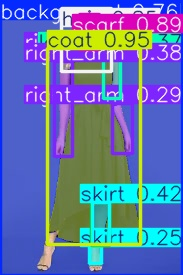

In [9]:
from PIL import Image

Image.open("/kaggle/working/runs/segment/predict2/download (6).jpg")